<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/EVA4_S2_mobilnet_v2_transfer_learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [4]:
!rm -rf hymenoptera_data
!wget -q "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
!unzip -o -qq hymenoptera_data.zip
!rm -rf hymenoptera_data.zip

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
dataset_sizes

{'train': 244, 'val': 153}

# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

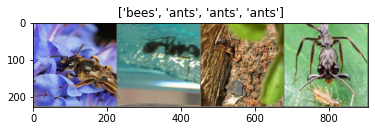

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[x] for x in classes[0:4]])

# 4. Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

# 5. Visualizing the model predictions
Generic function to display predictions for a few images

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


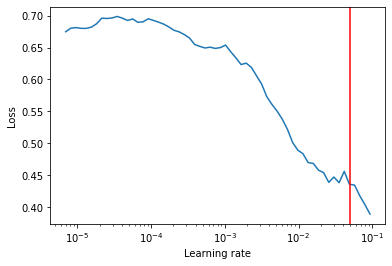

In [8]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.05) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [9]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.05, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [10]:
model_res = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6774 Acc: 0.5738
val Loss: 0.4979 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4695 Acc: 0.8361
val Loss: 0.3544 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.3724 Acc: 0.8770
val Loss: 0.2725 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3171 Acc: 0.8689
val Loss: 0.2469 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.2721 Acc: 0.9057
val Loss: 0.2231 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.2708 Acc: 0.9016
val Loss: 0.1957 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2061 Acc: 0.9262
val Loss: 0.2130 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2142 Acc: 0.9262
val Loss: 0.1795 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.1922 Acc: 0.9221
val Loss: 0.1833 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.1866 Acc: 0.9508
val Loss: 0.1829 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.1814 Acc: 0.9426
val Loss: 0.1625 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.1752 Acc: 0.9385
val Loss: 0.1764 Acc: 0.9477

Epoch 12/24
----------
t

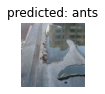

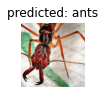

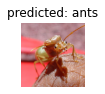

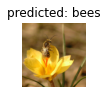

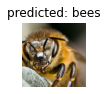

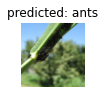

In [11]:
visualize_model(model_res, dataloaders, class_names, device)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


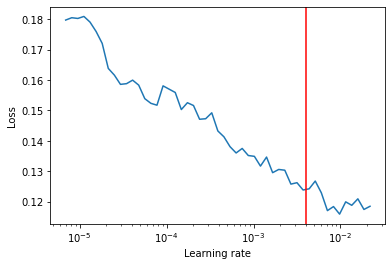

In [12]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.004) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [13]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.004, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

In [15]:
model_final = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1398 Acc: 0.9508
val Loss: 0.1446 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.1525 Acc: 0.9426
val Loss: 0.1388 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.1350 Acc: 0.9508
val Loss: 0.2154 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.1365 Acc: 0.9467
val Loss: 0.1482 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.1828 Acc: 0.9385
val Loss: 0.3154 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4519 Acc: 0.8238
val Loss: 0.2061 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1762 Acc: 0.9262
val Loss: 0.2609 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.1635 Acc: 0.9303
val Loss: 0.3924 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2636 Acc: 0.8975
val Loss: 0.5160 Acc: 0.8693

Epoch 9/24
----------
train Loss: 0.1963 Acc: 0.9385
val Loss: 0.3647 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.1390 Acc: 0.9385
val Loss: 0.4081 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2129 Acc: 0.9098
val Loss: 0.3487 Acc: 0.8954

Ep

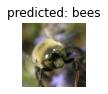

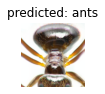

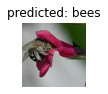

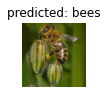

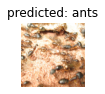

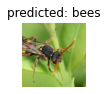

In [16]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()